设置环境

In [115]:
import torch, torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


设置训练参数

In [116]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
num_workers = 2
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
compose = transforms.Compose([
    # transforms.Resize(28),
    # transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28),
    # transforms.ColorJitter(brightness=1, contrast=0.1, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
torch.manual_seed(random_seed)


导入数据集

In [117]:
train_loader = DataLoader(
    torchvision.datasets.MNIST('./MNIST_data/train/', train=True, download=True, transform=compose),
    batch_size=batch_size_train, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(
    torchvision.datasets.MNIST('./MNIST_data/test/', train=False, download=True, transform=compose),
    batch_size=batch_size_test, shuffle=True, num_workers=num_workers)


查看数据集

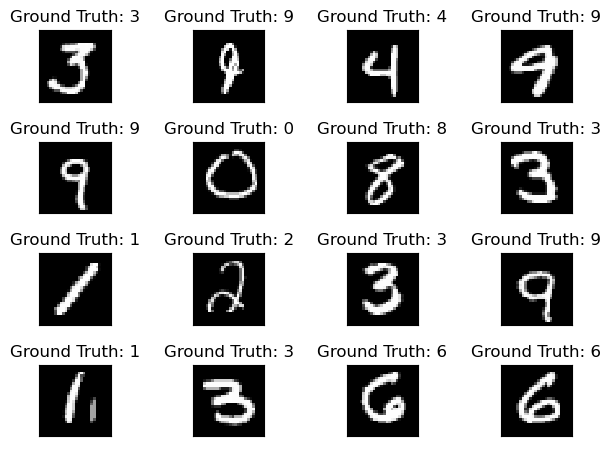

In [118]:
print(test_loader)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


In [119]:
# print(len(train_loader))
# print(len(test_loader))

构建网络

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.dense1 = nn.Linear(320, 50)
        self.dense2 = nn.Linear(50, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2_drop(self.conv2(x))))
        x = x.view(-1, 320)
        x = self.relu(self.dense1(x))
        x = F.dropout(x, training=self.training)
        x = self.dense2(x)
        return self.softmax(x)


network = Net()
optimizer = optim.SGD(network.parameters(),
                      lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')


# train(1)


def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduce="mean").item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


test()  # 不加这个，后面画图就会报错：x and y must be the same size
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
